In [1]:
# Import CIFAR 10 data
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
import cifar10

In [2]:
# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

In [3]:
data_path = "data/CIFAR-10/"
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
cifar10.maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [8]:
from cifar10 import img_size, num_channels, num_classes

In [9]:
img_size_cropped = 24

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

In [12]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [13]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [52]:
x1=images_test
# output is of shape (N, 3, 32, 32)
x1 = x1.reshape((-1,3,32,32))
# output is of shape (N, 32, 32, 3)
x1 = x1.transpose(0,2,3,1)
# put data back into a design matrix (N, 3072)
x1 = x1.reshape(-1, 3072)
x1.shape

(10000, 3072)

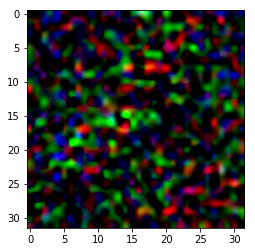

In [16]:
xm = np.mean( x1, axis = 0 )
x1 -= xm
# eigenvalue decomposition of the covariance matrix
C = np.dot( x1.T, x1 ) / x1.shape[1]
U, lam, V = np.linalg.svd( C )  # U[:, i] is the i-th eigenvector
#for i in range( D ):
#    print i, lam[i], lam[i] / lam[0]

# ZCA whitening
eps = 0
sqlam = np.sqrt( lam + eps )
Uzca = np.dot( U / sqlam[np.newaxis, :], U.T )
Z = np.dot( x1, Uzca.T )
plt.imshow(Z[10].reshape(32,32,3),interpolation='spline16')
plt.show()

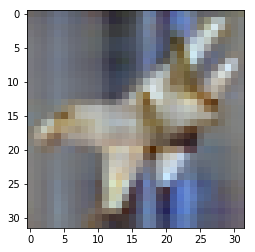

In [118]:
x1=images_test[10,:,:,:]
xm = np.mean( x1, axis = 0 )
x1 = x1-xm
x1 = x1 / np.sqrt((x1 ** 2).sum(axis=1))[:,None]
def show(i):
    i = i.reshape((32,32,3))
    m,M = i.min(), i.max()
    plt.imshow((i - m) / (M - m))
    plt.show()

show(x1)

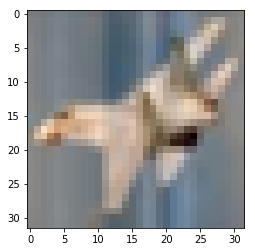

In [116]:
x1=images_test[10,:,:,:]
xm = np.mean( x1, axis = 0 )
x1 = x1 - xm
def show(i):
    i = i.reshape((32,32,3))
    m,M = i.min(), i.max()
    plt.imshow((i - m) / (M - m))
    plt.show()

show(x1)

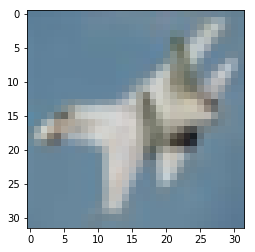

In [23]:
x1=images_test
plt.imshow(x1[10].reshape(32,32,3))
plt.show()

In [28]:
x1=images_test[10]
x1 = x1.reshape(-1, 3072)
cov = np.cov(x1, rowvar=True)   # cov is (N, N)
# singular value decomposition
U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,)
# build the ZCA matrix
epsilon = 1e-5
zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
# transform the image data       zca_matrix is (N,N)
zca = np.dot(zca_matrix, x1)    # zca is (N, 3072)
plt.imshow(zca[10].reshape(32,32,3))
plt.show()

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

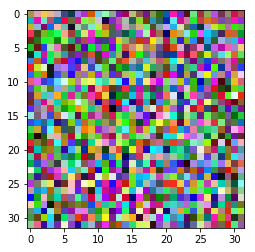

In [64]:
x1=images_test
x1 = x1.reshape(-1, 3072)
cov = np.dot( x1.T, x1 ) / x1.shape[1]   # cov is (N, N)
# singular value decomposition
U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,)
# build the ZCA matrix
epsilon = 1e-5
zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
# transform the image data       zca_matrix is (N,N)
zca = np.dot(x1,zca_matrix)    # zca is (N, 3072)
plt.imshow(zca[9].reshape(32,32,3))
plt.show()

In [61]:
x1=images_test[0:10]
x1 = x1.reshape(-1, 3072)
xm = np.mean( x1, axis = 0 )
x1 = x1-xm
x1.shape

(10, 3072)

In [59]:
x1=images_test[0:10]
x1 = x1.reshape(-1, 3072)
x1[0]

array([ 0.61960784,  0.43921569,  0.19215686, ...,  0.08235294,
        0.2627451 ,  0.43137255])

In [46]:
x1.shape

(10, 3072)

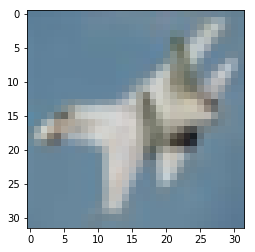

In [38]:
plt.imshow(x1.reshape(32,32,3))
plt.show()

In [45]:
def zca_whitening(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    N=32
    xm = np.mean( X, axis = 0 )
    X -= xm
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    return ZCAMatrix

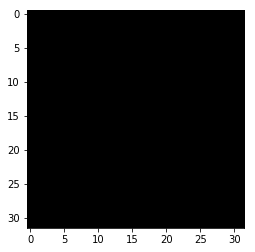

In [86]:
plt.imshow(images_test[10],interpolation='spline16')
plt.show()

In [16]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [17]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [18]:
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate only the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [19]:
distorted_images = pre_process(images=x, training=True)

In [20]:
session = tf.Session()

In [21]:
def get_test_image(i):
    return images_test[i, :, :, :], cls_test[i]

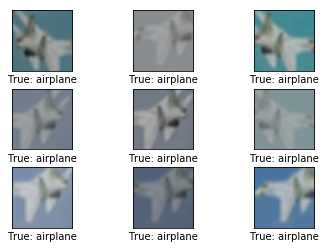

In [22]:
img, cls = get_test_image(10)
plot_distorted_image(img, cls)

In [23]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

In [24]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [25]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [26]:
_, loss = create_network(training=True)

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

In [28]:
y_pred, _ = create_network(training=False)

In [29]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [30]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [31]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
saver = tf.train.Saver()

In [33]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [34]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

In [35]:
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [36]:
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

In [37]:
save_dir = 'checkpoints/'

In [38]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [39]:
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [40]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_cnn-10000
Restored checkpoint from: checkpoints/cifar10_cnn-10000


In [41]:
train_batch_size = 64

In [42]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [43]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [44]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [45]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [46]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [47]:
def predict_cls_test():
    return predict_cls(images = images_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [48]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [49]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [50]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [51]:
def plot_layer_output(layer_output, image):
    # Assume layer_output is a 4-dim tensor
    # e.g. output_conv1 or output_conv2.

    # Create a feed-dict which holds the single input image.
    # Note that TensorFlow needs a list of images,
    # so we just create a list with this one image.
    feed_dict = {x: [image]}
    
    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_images))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i<num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [52]:
if False:
    optimize(num_iterations=10000)

In [54]:
optimize(num_iterations=1000)

Global Step:  10100, Training Batch Accuracy:  71.9%
Global Step:  10200, Training Batch Accuracy:  64.1%
Global Step:  10300, Training Batch Accuracy:  70.3%
Global Step:  10400, Training Batch Accuracy:  57.8%
Global Step:  10500, Training Batch Accuracy:  68.8%
Global Step:  10600, Training Batch Accuracy:  71.9%
Global Step:  10700, Training Batch Accuracy:  64.1%
Global Step:  10800, Training Batch Accuracy:  67.2%
Global Step:  10900, Training Batch Accuracy:  75.0%
Global Step:  11000, Training Batch Accuracy:  68.8%
Saved checkpoint.
Global Step:  11018, Training Batch Accuracy:  64.1%
Saved checkpoint.
Time usage: 0:03:57


Accuracy on Test-Set: 66.7% (6667 / 10000)
Example errors:


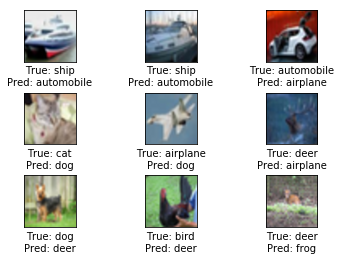

Confusion Matrix:
[767  42  29  11  19   7   7  24  40  54] (0) airplane
[ 26 837   1   4   3   4  10  16  16  83] (1) automobile
[ 91  24 471  66  87  70  55 102  12  22] (2) bird
[ 24  28  47 402  76 191  63 121  18  30] (3) cat
[ 28  13  30  39 584  35  38 209  14  10] (4) deer
[ 22  15  37 169  52 548  20 119   6  12] (5) dog
[ 16  18  36  53  63  26 735  29   8  16] (6) frog
[ 16  11  11  23  43  59   5 814   1  17] (7) horse
[ 96  71  10   8  13   3   4  14 724  57] (8) ship
[ 27 107   7   8   8   4   4  31  19 785] (9) truck
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


In [55]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

Min:  -0.55321, Max:   0.55456
Mean: -0.00243, Stdev: 0.16532


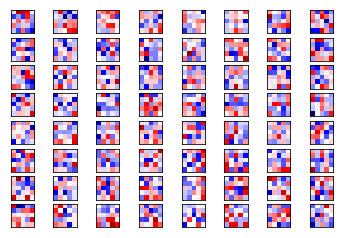

In [56]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

Min:  -0.17060, Max:   0.15241
Mean: -0.00138, Stdev: 0.03757


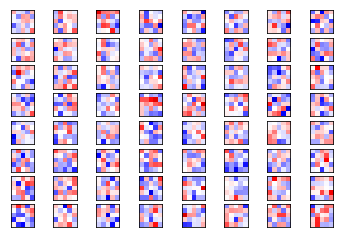

In [57]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [58]:
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

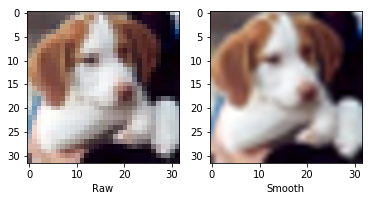

In [59]:
img, cls = get_test_image(16)
plot_image(img)

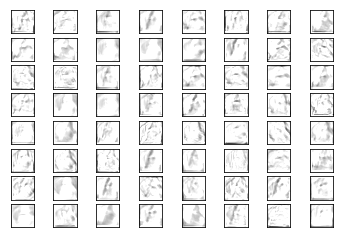

In [60]:
plot_layer_output(output_conv1, image=img)

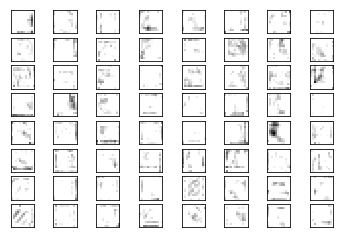

In [61]:
plot_layer_output(output_conv2, image=img)

In [62]:
label_pred, cls_pred = session.run([y_pred, y_pred_cls],
                                   feed_dict={x: [img]})

In [63]:
# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)

# Print the predicted label.
print(label_pred[0])

[ 0.002  0.01   0.009  0.152  0.002  0.785  0.001  0.028  0.     0.011]


In [77]:
class_names[3]

'cat'

In [78]:
class_names[5]

'dog'